In [1]:
# LS with n=10 and w=0.2 and 

In [2]:
#Here, we define 
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import *
import sympy
from sklearn.linear_model import LinearRegression
from sympy import re, im, I, E, symbols, exp
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import time

import tensorflow as tf

import glob
from tensorflow.keras.layers import Dense,Flatten,Cropping1D, Concatenate, MaxPooling1D, Dropout, Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import Hinge
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import KFold, train_test_split

import numpy as np
from scipy.special import pro_ang1
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


2025-01-31 21:32:25.024469: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 21:32:25.025792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 21:32:25.051696: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 21:32:25.052341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 21:32:27.723599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
def Orders(s):

    # First we store the pairs

    Pairs = []
    
    for i in range(0, s + 1):   # x ranges from 0 to s
        for j in range(0, s + 1):  # y ranges from 0 to s
            if  (i+1)*(j+1) <= s+1:  # The HC condition
                Pairs.append((i, j))  # We add them

    return Pairs

In [4]:
#Number of samples and parameters

max_order_HC = 100 # increase to 20 or more eventually

Nsamples = np.logspace(np.log10(max_order_HC), np.log10(10000), 10).astype(int)
Ntest= 1000

Para_slep = np.linspace(1, max_order_HC, 5).astype(int)

total_runs = 20

In [5]:
#Define the samples in (x, y) format
def samps(t):
    """
    Generates random samples as (x, y) pairs.

    Parameters:
    t : int or list/ndarray
        The number of (x, y) pairs to generate.

    Returns:
    np.ndarray
        An array of shape (t, 2) where each row is an (x, y) pair.
    """
    # Determine total samples
    total_samples = int(t[0]) if isinstance(t, (list, np.ndarray)) else int(t)
    
    # Generate random (x, y) pairs
    Values = np.random.uniform(-1, 1, (total_samples, 2))
    
    return Values

In [8]:
#Returns the multiple of the Slepian basis function

def NorSlep(j, c):
    b = 0 # Alpha parameter for the PSAF
    theta = np.linspace(-1, 1, 200)
    
    psaf_values = pro_ang1(b, j, c, theta)
    psaf_values = psaf_values[0] 
    
    psaf_values = psaf_values[1:199]
    l2_norm = np.linalg.norm(psaf_values)/np.sqrt(len(theta)-1)
    
    
    return l2_norm

norms_ = np.zeros((Para_slep[-1]+1))
for k in range(len(norms_)):
    norms_[k] = NorSlep(k, 16)


In [11]:
# Function to compute the PSWF (Prolate Spheroidal Wave Function)
def PSWF(x, j, c, norms_):
    """
    Computes a multiple of the Prolate Spheroidal Wave Function (PSWF) at a given value of x.

    Parameters:
    x : float
        The point at which the PSWF is evaluated.
    j : int
        The index for the PSWF mode.
    c : float
        The constant related to the frequency parameter.
    norms_ : array-like
        Precomputed normalization constants for the PSWF modes.

    Returns:
    float
        The value of the PSWF at the point x, normalized by its L2 norm.
    """
    
    b = 0  # Alpha parameter for the PSAF (assumed to be 0 in this case)
    
    # Calculate the PSAF values for the given modes
    psaf_values = pro_ang1(b, j, c, x)
    
    # Extract the first value of the result 
    psaf_values = psaf_values[0]
    
    # Extract the normalization constant for the current mode
    l2_norm = norms_[j]
    
    # Return the normalized PSWF value
    return psaf_values / l2_norm



In [12]:
def product_of_pswf(x1, x2, i, j, c):
    """
    This function computes the product of two PSWFs with different indices j1 and j2
    evaluated at points x1 and x2, respectively, and normalizes the result.
    """
    pswf1 = PSWF(x1, i, c)

    # Compute the second PSWF at x2 with mode j2
    pswf2 = PSWF(x2, j, c)

    # Compute the product of both PSWFs
    product = pswf1 * pswf2

    # Return the product (this is already normalized)
    return product

In [13]:
def Matrix(samp, k):
     """
    Computes a matrix A where each entry A[m, i] is the product of PSWF evaluated at 
    (x, y) in the given sample 'samp' for the 'i' order of the PSWF.

    Parameters:
    samp : ndarray, shape (n_samples, 2)
        The input sample points, where each entry contains coordinates (x, y).
    k : int
        The parameter used for determining the orders of the Prolate Spheroidal Wave Functions.

    Returns:
    A : ndarray, shape (n_samples, len(Ords))
        The matrix A computed from the PSWF values at the sample points for the given orders.
    """
    
    # Get the orders associated with the given 'k'
    
   
    Ords = Orders(k)
    
    A = np.zeros((len(samp), len(Ords)))
    
    # Iterate through the sample points (samp)
    for m in range(len(samp)):
        x, y = samp[m]  # Extract x and y from the k-th sample
        for i in range(len(Ords)):# Loop through 'ordens' indices
                # Compute the value for the matrix entry A[m, i] using the product of PSWF            
                A[m, i] = product_of_pswf(x, y, Ords[i][0], Ords[i][1], 16)  # Compute the value for the matrix
    
    return A


In [14]:
# This is the function that we approximate
def funct(z):
    """
    Function that computes a value based on the input coordinates (x, y).
    The function is of the form: cos(0.2 * x) * cos(0.2 * y) * exp(-pi * (x^2 + y^2)).

    Parameters:
    z : ndarray, shape (n_samples, 2)
        An array containing pairs of coordinates (x, y).

    Returns:
    g : ndarray, shape (n_samples,)
        The computed values of the function at each (x, y) pair.
    """
    
    # Extract x and y coordinates from the input array
    x, y = z[:, 0], z[:, 1]
    
    # Define the function g(x, y)
    g = np.cos(0.2 * x) * np.cos(0.2 * y) * np.exp(-np.pi * (x**2 + y**2))
    
    return g


In [3]:
import numpy as np

# Initialize the error vector
MSE = np.zeros([len(Para_slep), len(Nsamples), total_runs])

start_time = time.time()
total_iterations =  total_runs * len(Para_slep) * len(Nsamples)
counter = 0

#Run multiple times

for run in range(total_runs):
           
    
    # Produce the matrix once, then reuse it
    SamSet_ = samps(Nsamples[-1])  # Generate 2D samples
    y_ = funct(SamSet_)  # Compute function values for (x, y) pairs
    
    # Generate the test set
    TestSet = samps(Ntest)  # 2D array of test samples (x, y)
    Values_test = funct(TestSet)  # Function values for test set

    
  
    
    for orde in range(len(Para_slep)):
        
        t= Para_slep[orde]
        Pairs_order = Orders(t)        
      
        
        A_ = Matrix(SamSet_, t)  # Use Para_slep appropriately

        test_PSWF_matrix_ =Matrix(TestSet, t)
        
       
         
        for k in range(len(Nsamples)):
            
            # Generate sample and test sets
            A = A_[:Nsamples[k], :]
            SamSet = SamSet_[:Nsamples[k]]
            y = y_[:Nsamples[k]]
            

            #Values_test = funct(TestSet)

            # Solve the linear regression problem using lstsq (least squares)
            x, _, _, _ = np.linalg.lstsq(A.T@A, A.T@y, rcond=None)

            # Calculate the linear combination on the test set in a vectorized manner
            linear_combination_t = test_PSWF_matrix_@x

            # Calculate the error
            Err = np.linalg.norm(linear_combination_t - Values_test) / np.sqrt(Ntest)

            MSE[orde, k, run] = Err
            
            counter += 1
            now_time = time.time()
            print('Error: ' + str(Err) +  ', Progress: ' + format(100*counter / total_iterations, '.2f') + '%' + ', approx. ' + format((total_iterations-counter)*(now_time -  start_time)/counter, '.1f') + ' seconds remaining.')





NameError: name 'Para_slep' is not defined

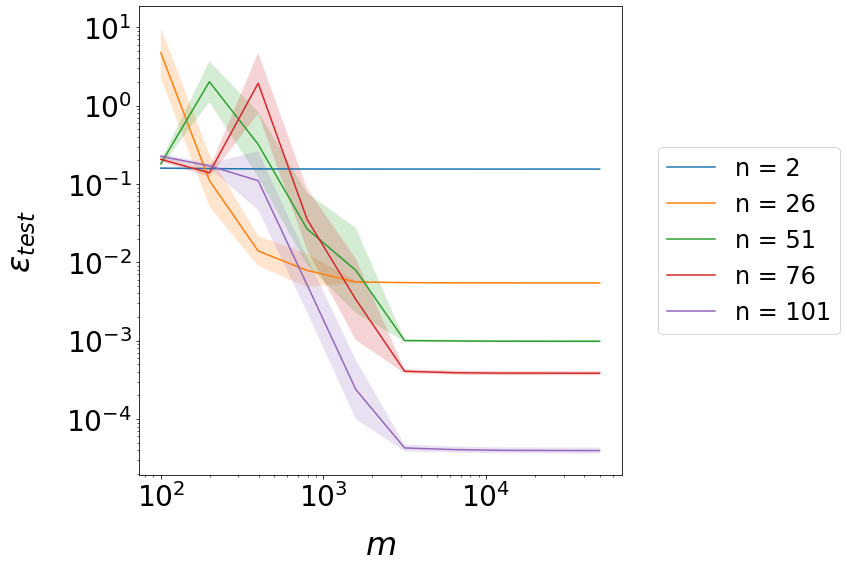

In [26]:
#Plot Error over training set sizes
plt.figure(figsize=(12, 8))  #Size
results_mean = np.mean(MSE, axis = 2)
results_lower = np.std(MSE, axis = 2)/results_mean # 90% confidence intervals


for i in range(len(Para_slep)):
    plt.loglog(Nsamples, results_mean[i,:], label=f'n = {Para_slep[i]+1}')
    plt.fill_between(Nsamples, results_mean[i,:]/(1+results_lower[i,:]), results_mean[i,:]*(1+results_lower[i,:]),  alpha=0.2)



plt.xlabel(r'$m$', fontsize=32, labelpad=18)
plt.ylabel(r'$\epsilon_{test}$', fontsize=32, labelpad=28)


# Increase font size of axis tick labels
plt.tick_params(axis='both', which='major', labelsize=28)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=28)  # Minor ticks

plt.legend(fontsize=28, loc='lower left')

plt.legend(
    fontsize=24,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place the legend to the right of the plot
    ncol=1  # Single column for legend entries
)

plt.tight_layout()  

plt.savefig("errorvsparams2D.pdf")


plt.show()
